In [ ]:
pip install pyarrow geoarrow-pyarrow geopandas earthaccess jupyterlab_vim

In [6]:
import h5py
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import geoarrow.pyarrow as ga
from geoarrow.pyarrow import io
import geopandas as gpd
import numpy as np
import shapely
from datetime import datetime

import json
import earthaccess
from earthaccess.results import DataGranule
import fsspec

In [ ]:
def result_bbox(result: DataGranule):
    points = result["umm"]["SpatialExtent"]["HorizontalSpatialDomain"]["Geometry"]["GPolygons"][0]["Boundary"]["Points"]

    longitudes = [point['Longitude'] for point in points]
    latitudes = [point['Latitude'] for point in points]

    min_lon, min_lat = min(longitudes), min(latitudes)
    max_lon, max_lat = max(longitudes), max(latitudes)
    bbox = shapely.geometry.box(min_lon, min_lat, max_lon, max_lat)
    return bbox

In [40]:
def results_bounds(results: list[DataGranule]):
    union_bbox = result_bbox(results[0])
    for result in results:
        bbox = result_bbox(result)  
        union_bbox = union_bbox.union(bbox)
    return list(union_bbox.envelope.bounds)

In [25]:
geo_metadata = {
    "columns": {
        "geometry": {
            "bbox": [
                -180.0,
                -90.0,
                180.0,
                83.6451
            ],
            "covering": {
                "bbox": {
                    "xmax": [
                        "bbox",
                        "xmax"
                    ],
                    "xmin": [
                        "bbox",
                        "xmin"
                    ],
                    "ymax": [
                        "bbox",
                        "ymax"
                    ],
                    "ymin": [
                        "bbox",
                        "ymin"
                    ]
                }
            },
            "crs": {
                "$schema": "https://proj.org/schemas/v0.6/projjson.schema.json",
                "area": "World.",
                "bbox": {
                    "east_longitude": 180,
                    "north_latitude": 90,
                    "south_latitude": -90,
                    "west_longitude": -180
                },
                "coordinate_system": {
                    "axis": [
                        {
                            "abbreviation": "Lon",
                            "direction": "east",
                            "name": "Geodetic longitude",
                            "unit": "degree"
                        },
                        {
                            "abbreviation": "Lat",
                            "direction": "north",
                            "name": "Geodetic latitude",
                            "unit": "degree"
                        }
                    ],
                    "subtype": "ellipsoidal"
                },
                "datum_ensemble": {
                    "accuracy": "2.0",
                    "ellipsoid": {
                        "inverse_flattening": 298.257223563,
                        "name": "WGS 84",
                        "semi_major_axis": 6378137
                    },
                    "id": {
                        "authority": "EPSG",
                        "code": 6326
                    },
                    "members": [
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1166
                            },
                            "name": "World Geodetic System 1984 (Transit)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1152
                            },
                            "name": "World Geodetic System 1984 (G730)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1153
                            },
                            "name": "World Geodetic System 1984 (G873)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1154
                            },
                            "name": "World Geodetic System 1984 (G1150)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1155
                            },
                            "name": "World Geodetic System 1984 (G1674)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1156
                            },
                            "name": "World Geodetic System 1984 (G1762)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1309
                            },
                            "name": "World Geodetic System 1984 (G2139)"
                        }
                    ],
                    "name": "World Geodetic System 1984 ensemble"
                },
                "id": {
                    "authority": "OGC",
                    "code": "CRS84"
                },
                "name": "WGS 84 (CRS84)",
                "scope": "Not known.",
                "type": "GeographicCRS"
            },
            "edges": "planar",
            "encoding": "WKB",
            "geometry_types": [
                "Point",
            ]
        }
    },
    "primary_column": "geometry",
    "version": "1.1.0-dev"
}

In [52]:
def datasets_to_fields(group: h5py.Group):
    fields = []
    for key in group.keys():
        if isinstance(group[key], h5py.Dataset):
            dtype = group[key].dtype
            numpy_dtype = dtype.newbyteorder("=")
            arrow_type = pa.from_numpy_dtype(numpy_dtype)
            fields.append((key, arrow_type))
    return fields

In [27]:
def create_pyarrow_schema(template_file: h5py.File, geo_metadata: dict) -> pa.schema:
    land_segments_group = template_file["gt1l"]["land_segments"]
    canopy_group = template_file["gt1l"]["land_segments"]["canopy"]
    terrain_group = template_file["gt1l"]["land_segments"]["terrain"]  
    
    land_segment_fields = datasets_to_fields(land_segments_group)
    geometry_field = pa.field("geometry", pa.binary(), metadata={
        "encoding": "WKB",
        "geometry_types": "POINT"
    })
    land_segment_fields.append(geometry_field)
    canopy_fields = datasets_to_fields(canopy_group)
    terrain_fields = datasets_to_fields(terrain_group)

    fields = land_segment_fields + canopy_fields + terrain_fields

    metadata = json.dumps(geo_metadata).encode('utf-8')
    schema = pa.schema(fields, metadata={b"geo": metadata})
    return schema

In [28]:
def get_group_chunks(group: h5py.Group, offset: int, chunk_size: int) -> list[np.array]:
    chunks = []
    for key in group.keys():
        if isinstance(group[key], h5py.Dataset):
            if len(group[key].chunks) == 1:
                chunks.append(group[key][offset:offset+chunk_size])
            # Handle variables with land segment chunking
            elif len(group[key].chunks) == 2:
                chunks.append(group[key][offset:offset+chunk_size, 0])
    return chunks

In [51]:
def chunks_to_tables(result: DataGranule, fs, schema: pa.schema) -> list[pa.Table]:
    tables = []
    url = result.data_links(access="direct")[0]
    print(url)
    with fs.open(url, 'rb') as f:
        file = h5py.File(f)
        land_segments_group = file["gt1l"]["land_segments"]
        canopy_group = file["gt1l"]["land_segments"]["canopy"]
        terrain_group = file["gt1l"]["land_segments"]["terrain"] 

        chunk_size = land_segments_group["latitude"].chunks[0]
        size = land_segments_group["latitude"].size
        number_of_chunks = (size // chunk_size) + 1
        
        for n in range(number_of_chunks):
            offset = n * chunk_size
            land_segment_chunks = get_group_chunks(land_segments_group, offset, chunk_size)
            # Populate geometry field
            geometries = []
            for lat, lon in zip(
                land_segments_group["latitude"][offset:offset+chunk_size],
                land_segments_group["longitude"][offset:offset+chunk_size]
            ):
                point = shapely.Point(lon, lat)
                point_wkb = shapely.to_wkb(point, flavor="iso")
                geometries.append(point_wkb)
            land_segment_chunks.append(geometries)

            canopy_chunks = get_group_chunks(canopy_group, offset, chunk_size)
            terrain_chunks = get_group_chunks(terrain_group, offset, chunk_size)
            chunks = land_segment_chunks + canopy_chunks + terrain_chunks
            table = pa.Table.from_arrays(chunks, schema=schema)   
            tables.append(table)
    return tables

In [49]:
def write_results_by_group(results_list: list[DataGranule], num_files_per_group: int, fs, schema: pa.schema, geo_metadata: dict):
    for i in range(0, len(results_list), num_files_per_group):
        print(i)
        result_group_tables = []
        results_group = results_subset[i:i+num_files_per_group]
        # Generate bbox for results_group
        results_group_bounds = results_bounds(results_group)
        result_group_metadata = schema.metadata.copy()
        geo_metadata["columns"]["geometry"]["bbox"] = results_group_bounds
        result_group_metadata[b"geo"] = json.dumps(geo_metadata).encode('utf-8')
        result_group_schema = schema.with_metadata(result_group_metadata)
        
        table_writer = pq.ParquetWriter(f'output.parquet_{i}', result_group_schema)
        for result in results_group:
            results_tables = chunks_to_tables(result, fs, result_group_schema)
            result_group_tables.extend(results_tables)
        
        combined_table = pa.concat_tables(result_group_tables)
        table_writer.write_table(combined_table)
        table_writer.close()

In [31]:
#earthaccess.login()
results = earthaccess.search_data(
    short_name="ATL08",
    cloud_hosted=True,
    temporal=("2023-09-02", "2023-09-04"),
    count=-1
)

Granules found: 307


In [32]:
sorted_results = sorted(results, key=lambda r : datetime.strptime(r['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'], '%Y-%m-%dT%H:%M:%S.%fZ'))

In [33]:
s3 = fsspec.filesystem('s3')

In [34]:
f = s3.open(results[0].data_links(access="direct")[0], 'rb')
file = h5py.File(f)
file

<HDF5 file "ATL08_20230902002616_11272010_006_01.h5>" (mode r)>

In [ ]:
template_schema = create_pyarrow_schema(file, geo_metadata)
template_schema

In [36]:
results_subset = sorted_results[0:20]

In [ ]:
write_results_by_group(results_subset, 10, s3, template_schema, geo_metadata)

0
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902002616_11272010_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902003357_11272011_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902003940_11272012_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902004721_11272013_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902005323_11272014_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902010026_11282001_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902012632_11282005_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902013157_11282006_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902014027_11282007_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/09/02/ATL08_20230902014729_1128200

In [56]:
gdf = gpd.read_parquet('output.parquet_10')
gdf.total_bounds

array([-27.29138756, -88.03723145, 175.26828003,  83.82554626])

In [ ]:
gdf = gpd.read_parquet('output.parquet_0')
gdf.total_bounds

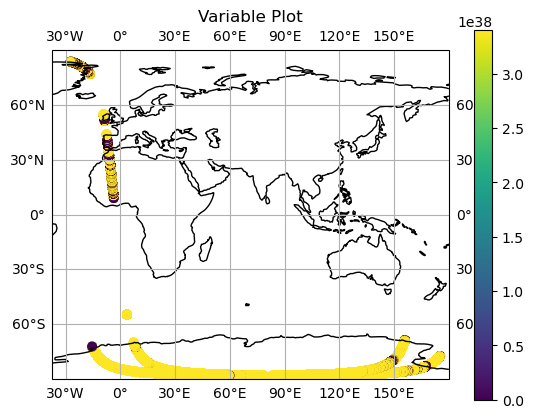

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs

crs = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw=dict(projection=crs))
gdf.plot(column='h_canopy', ax=ax, legend=True, cmap='viridis')
ax.set_title('Variable Plot')

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)

# Show plot
plt.show()

In [21]:
plt.show()